In [13]:
import os
import MySQLdb
from dotenv import load_dotenv
import pandas as pd
import numpy as np
load_dotenv()

def database_query(sql_query):
    try:
        connection = MySQLdb.connect(
        host=os.getenv("DATABASE_HOST"),
        user=os.getenv("DATABASE_USERNAME"),
        passwd=os.getenv("DATABASE_PASSWORD"),
        db=os.getenv("DATABASE"),
        autocommit=True,
        # ssl_mode="VERIFY_iDENTITY",
        ssl={"ca": "/etc/ssl/certs/ca-certificates.crt"})
    except:
        connection = MySQLdb.connect(
        host=os.environ["DATABASE_HOST"],
        user=os.environ["DATABASE_USERNAME"],
        passwd=os.environ["DATABASE_PASSWORD"],
        db=os.environ["DATABASE"],
        autocommit=True,
        # ssl_mode="VERIFY_iDENTITY",
        ssl={"ca": "/etc/ssl/certs/ca-certificates.crt"})
    try:
        c = connection.cursor()
        c.execute(sql_query)
        results = c.fetchall()
        return results
    except MySQLdb.Error as e:
        print("MySQL Error:", e)
    finally:
        c.close()
        connection.close()


sql_query = '''

select
    title
    ,department
    ,location
    ,salary
    ,closing_date
    ,uid
    ,scraped_date
from 
    all_time_listings

'''

df = pd.DataFrame(database_query(sql_query))
df.columns = ['title', 'department', 'location', 'salary', 'closing_date', 'uid', 'scraped_date']
df.head()

,title,department,location,salary,closing_date,uid,scraped_date
0,Senior Data Analyst - Corporate Performance,Companies House,"Cardiff, Wales, CF14 3UZ","46,588",2024-03-05,153376,2024-02-21
1,Kitchen Steward,House of Commons,Westminster,"24,959",2024-05-19,200324,2024-01-04
2,National Professional Advisor (for People with...,Care Quality Commission,"East Midlands (England), East of England, Lond...","70,000",2024-02-26,24711,2024-02-13
3,Commis Chef,House of Commons,Westminster,"24,959",2024-05-19,255755,2024-01-04
4,Recreation Works Supervisor,Forestry Commission,"Burley Office, Burley, Hampshire BH24 4HS","26,534",2024-01-14,257501,2024-01-04


In [14]:
from plotnine import ggplot, scale_fill_gradient, scale_color_continuous, scale_color_gradient, aes, geom_point, geom_col, geom_line, geom_histogram, geom_boxplot, facet_wrap, theme, element_text, element_blank, element_rect, element_line, labs, scale_x_continuous, scale_y_continuous, scale_fill_manual, scale_color_manual, scale_linetype_manual, scale_shape_manual, scale_size_manual, scale_alpha_manual, coord_flip, coord_cartesian, coord_fixed

Plot showing median salaries by department

In [15]:
df['salary_int'] = df['salary'].str.replace(',','')
df['salary_int'] = df['salary_int'].astype(float)
df['scraped_date_date'] = pd.to_datetime(df['scraped_date'])
df['week_commencing'] = df['scraped_date_date'].dt.to_period('W').dt.start_time
df['salary_int'].describe()
daily_salary = df[['week_commencing','salary_int','department','location']].groupby(['week_commencing','salary_int','department','location']).mean().reset_index()
department_salary = df.groupby('department').agg({'salary_int':'median','uid':'count'}).reset_index().sort_values('salary_int', ascending=False)
department_salary.columns = ['department','salary_int','Number of Postings']

# department_salary = pd.concat([department_salary.nlargest(5, 'salary_int').reset_index(),department_salary.nsmallest(5, 'salary_int').reset_index()], axis=0, ignore_index=True).sort_values('salary_int', ascending=False)

plot = (
    ggplot(department_salary, aes(x="reorder(department, salary_int, ascending=False)", y='salary_int'
                                    ,color='Number of Postings', fill='Number of Postings'
                                   ))

    + geom_col()
    # + theme(legend_position='none')
    + scale_color_gradient(limits=[10, 100], labels=['<10', '>100'], breaks=[10, 100])
    + scale_fill_gradient(limits=[10, 100], labels=['<10', '>100'], breaks=[10, 100])
    + labs(title=f"Civil Service Departments Median Salary Comparison: {df['scraped_date_date'].dt.date.min()} to {df['scraped_date_date'].dt.date.max()}"
           , x='Department'
           , y='Median Salary (£)'
           , caption='Source: Civil Service Jobs (https://www.civilservicejobs.service.gov.uk/)')
    + theme(axis_text_x=element_text(angle=90, face='bold'))
    + theme(axis_text_x=element_text(size=6))
    + theme(axis_text_y=element_text(size=6))
    + theme(plot_caption=element_text(size=6, face='italic'))
    + theme(plot_title=element_text(size=20, face='bold'))
)

plot.save("department_salary.png", width=20, height=10, units='in', dpi=300)


/home/codespace/.python/current/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 20 x 10 in image.
/home/codespace/.python/current/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: department_salary.png


In [16]:
##department median salary QA

pass_qa = True
number_of_departments = 0
def qa_check(df, department):
    global pass_qa
    global number_of_departments
    department_median = df[df['department']==department]['salary_int'].values[0]
    df_department = df[df['department']==department]
    difference = department_median - df_department['salary_int'].describe().values[5]
    if difference > 0:
        print(f"Variation in QA check for {department}")
        pass_qa = False
    else:
        number_of_departments += 1


for i in df['department'].unique():
    qa_check(department_salary, i)
if pass_qa:
    print("QA checks passed. Number of departments checked: ", number_of_departments)
else:
    print("QA checks failed")

QA checks passed. Number of departments checked:  161


See if we can pull number of posts out of the data as well to improve salary averages?
Compare highest salaries with behvaiours to establish highest-value behaviours

In [17]:
application_df = pd.DataFrame(database_query('select * from all_time_ad_qualities'))

In [18]:
application_df.columns = [
        'uid', 
        'developing_self_and_others', 
        'leadership',
        'making_effective_decisions',
        'seeing_the_big_picture',
        'managing_a_quality_service',
        'working_together',
        'communicating_and_influencing',
        'changing_and_improving',
        'delivering_at_pace',
        'apply_at_advertisers_site',
        'cv',
        'personal_statement',
        'reference_request',
        'application_form',
        'cover_letter',
        'presentation',
        'interview',
        'portfolio',
        'test']

In [19]:
df['uid'] = df['uid'].astype(int)
application_df['uid'] = application_df['uid'].astype(int)
combined_df = pd.merge(df, application_df, on='uid', how='left')
combined_df.head(1)

,title,department,location,salary,closing_date,uid,scraped_date,salary_int,scraped_date_date,week_commencing,...,apply_at_advertisers_site,cv,personal_statement,reference_request,application_form,cover_letter,presentation,interview,portfolio,test
0,Senior Data Analyst - Corporate Performance,Companies House,"Cardiff, Wales, CF14 3UZ","46,588",2024-03-05,153376,2024-02-21,46588.0,2024-02-21,2024-02-19,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [20]:
behaviours_df = combined_df[['department', 'week_commencing', 'salary_int',
        'developing_self_and_others', 
        'leadership',
        'making_effective_decisions',
        'seeing_the_big_picture',
        'managing_a_quality_service',
        'working_together',
        'communicating_and_influencing',
        'changing_and_improving',
        'delivering_at_pace']]

def salary_bucket_func(salary_int):
        bucket = '£90k+'
        salary_bucket_dict = {
                90000: '£70k-£90k'
                , 70000: '£50k-£70k'
                , 50000: '£30k-£50k'
                , 30000: '<£30k'}
        try:
                for salary in salary_bucket_dict.keys():
                        if salary_int <= salary:
                                bucket = salary_bucket_dict[salary]
                                

                
        except:
                pass
        return bucket

salary_bucket_func_vectorised = np.vectorize(salary_bucket_func)
behaviours_df['salary_bucket'] = salary_bucket_func_vectorised(behaviours_df['salary_int'])

grouped_behaviours = behaviours_df[['department'
                                    , 'week_commencing'
                                    , 'salary_bucket'
                                    , 'developing_self_and_others'
                                    , 'leadership'
                                    , 'making_effective_decisions'
                                    , 'seeing_the_big_picture'
                                    , 'managing_a_quality_service'
                                    , 'working_together'
                                    , 'communicating_and_influencing'
                                    , 'changing_and_improving'
                                    , 'delivering_at_pace']].groupby(['department','week_commencing','salary_bucket']).sum().reset_index()

/tmp/ipykernel_2502/2372389155.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
melted_behaviours = pd.melt(grouped_behaviours, id_vars=['department', 'week_commencing', 'salary_bucket'], value_vars=['developing_self_and_others', 'leadership', 'making_effective_decisions', 'seeing_the_big_picture', 'managing_a_quality_service', 'working_together', 'communicating_and_influencing', 'changing_and_improving', 'delivering_at_pace'])
melted_behaviours.columns = ['department', 'week_commencing', 'salary_bucket', 'behaviour', 'count']

melted_behaviours = melted_behaviours[['salary_bucket', 'behaviour', 'count']].groupby(['salary_bucket', 'behaviour']).sum().reset_index()

def behaviour_cleaner(behaviour):
    behaviour_dict = {
        'developing_self_and_others': 'Developing Self and Others'
        , 'leadership': 'Leadership'
        , 'making_effective_decisions': 'Making Effective Decisions'
        , 'seeing_the_big_picture': 'Seeing the Big Picture'
        , 'managing_a_quality_service': 'Managing a Quality Service'
        , 'working_together': 'Working Together'
        , 'communicating_and_influencing': 'Communicating and Influencing'
        , 'changing_and_improving': 'Changing and Improving'
        , 'delivering_at_pace': 'Delivering at Pace'
    }
    return behaviour_dict[behaviour]

melted_behaviours['behaviour'] = melted_behaviours['behaviour'].apply(behaviour_cleaner)

df['salary_bucket'] = salary_bucket_func_vectorised(df['salary_int'])
total_bucket_counts = df['salary_bucket'].value_counts().reset_index()
total_bucket_counts.columns = ['salary_bucket', 'total_count']
melted_behaviours['cum_sum'] = (melted_behaviours.groupby(['salary_bucket'])['count'].transform('max'))
melted_behaviours = pd.merge(melted_behaviours, total_bucket_counts, how='left')
melted_behaviours['percentage'] = (melted_behaviours['count'] / melted_behaviours['total_count']) * 100

behaviour_plot = (
    ggplot(melted_behaviours, aes(x='behaviour', y='percentage', color='behaviour', fill='behaviour'))
    + geom_col()
    + facet_wrap('salary_bucket', nrow=1)
    + labs(title='Behaviours Requested by Salary Bucket'
           , x=''
           , y='Percentage of Postings Mentioning Behaviour (%)'
           , caption='Source: Civil Service Jobs (https://www.civilservicejobs.service.gov.uk/)')
    + theme(axis_title_y=element_text(size='14'))
    # + theme(legend_position='none')
    + theme(axis_text_x=element_text(color='white'))
    + theme(axis_ticks_x=element_text(color='white'))
    + theme(legend_title=element_blank())
    #custom fill colours
    + scale_fill_manual(values=['#87CEEB', '#FFD300', '#FC6A03', '#FFC0CB', '#7E38B7', '#378805', '#1E2F97', '#7c3f00', '#2f2f2f'])
    + scale_color_manual(values=['#87CEEB', '#FFD300', '#FC6A03', '#FFC0CB', '#7E38B7', '#378805', '#1E2F97', '#7c3f00', '#2f2f2f'])
)

behaviour_plot.save("behaviour_plot.png", width=20, height=10, units='in', dpi=300)

/home/codespace/.python/current/lib/python3.10/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 20 x 10 in image.
/home/codespace/.python/current/lib/python3.10/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: behaviour_plot.png


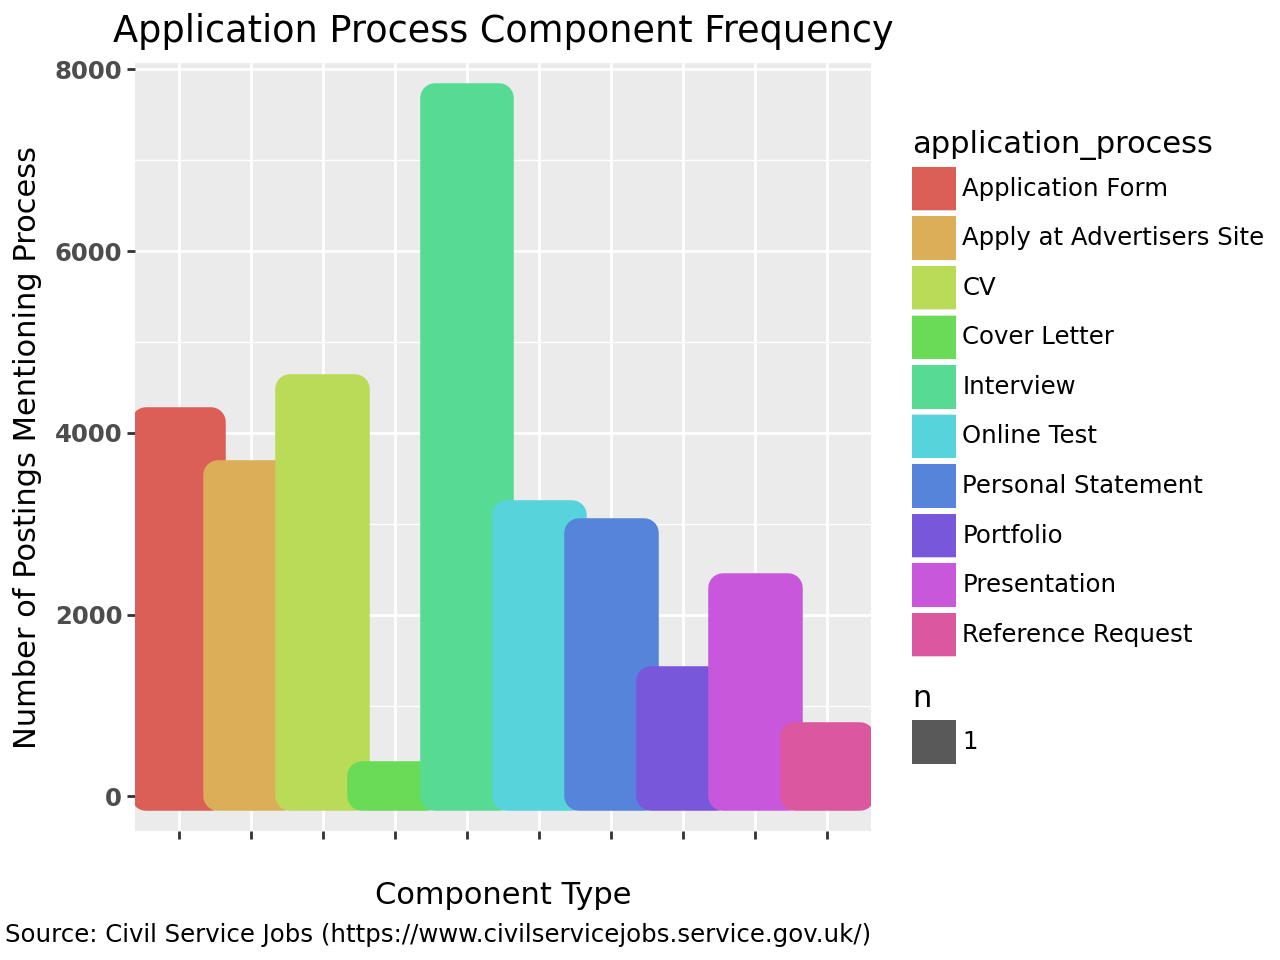

In [22]:
application_process_df = application_df[[
        'uid', 
        'apply_at_advertisers_site',
        'cv',
        'personal_statement',
        'reference_request',
        'application_form',
        'cover_letter',
        'presentation',
        'interview',
        'portfolio',
        'test']]

melted_application_process_df = pd.melt(application_process_df, id_vars=['uid'], value_vars=['apply_at_advertisers_site', 'cv', 'personal_statement', 'reference_request', 'application_form', 'cover_letter', 'presentation', 'interview', 'portfolio', 'test'])
melted_application_process_df.columns = ['uid', 'application_process', 'count']
melted_application_process_df = melted_application_process_df.groupby('application_process').sum().reset_index()

def application_process_cleaner(application_process):
    application_process_dict = {
        'apply_at_advertisers_site': 'Apply at Advertisers Site'
        , 'cv': 'CV'
        , 'personal_statement': 'Personal Statement'
        , 'reference_request': 'Reference Request'
        , 'application_form': 'Application Form'
        , 'cover_letter': 'Cover Letter'
        , 'presentation': 'Presentation'
        , 'interview': 'Interview'
        , 'portfolio': 'Portfolio'
        , 'test': 'Online Test'
    }
    return application_process_dict[application_process]

melted_application_process_df['application_process'] = melted_application_process_df['application_process'].apply(application_process_cleaner)

from plotnine import geom_bar

application_process_plot = (

    ggplot(melted_application_process_df, aes(x='application_process', y='count', color='application_process', fill='application_process'))
    + geom_bar(stat='sum')
    + labs(title='Application Process Component Frequency'
           , x='Component Type'
           , y='Number of Postings Mentioning Process'
           , caption='Source: Civil Service Jobs (https://www.civilservicejobs.service.gov.uk/)')
    + theme(axis_text_y=element_text(face='bold'))
    #remove x axis text
    + theme(axis_text_x=element_text(color='white'))
)

application_process_plot

In [23]:
full_ad_text_testing = database_query('select uid, full_ad_text from all_time_listings limit 1 where uid = "153376" '  )
print(full_ad_text_testing)

MySQL Error: (1105, "syntax error at position 62 near 'where'")
None


In [24]:
print(len(full_ad_text_testing[0][0]))
# QA using uid 153376, which contrains the below
#presentation
#interview
#cv
#personal statement
#particular concern is the low CV figures in the above visual

TypeError: 'NoneType' object is not subscriptable